Predicting the survival of patients with heart failure from [data collected in 2015](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

In [ ]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# EDA

In [ ]:
df

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                      1  265000.00               1.9           130    1   
1                      0  263358.03               1.1           136    1   
2                      0  162000.00               1.3           129    1   
3                      0  210000.00               1.9           137    1   
4                      0  327000.00               2.7           116    0   
..                   ...        ...               ...           ...  ...   
294                    1  155000.00               1.1           143    1   
295                    0  270000.00               1.2           139    0   
296                    0  742000.00               0.8           138    0   
297                    0  140000.00               1.4           140    1   
298                    0  395000.00               1.6           136    1   

     smoking  time  DEATH_EVENT  
0          0     4            1  
1          0     6            1  
2          1     7            1  
3          0     7            1  
4          0     8            1  
..       ...   ...          ...  
294        1   270            0  
295        0   271            0  
296        0   278            0  
297        1   280            0  
298        1   285            0  

[299 rows x 13 columns]

In [ ]:
def summary(df):
  print(f"There are {df.shape[0]} medical records of patients and {df.shape[1]} clinical attributes.")
  print('The binary variables are: anaemia, diabetes, high bp, sex, smoking, and death event. Death Event is the variable we are interested in predicting.')
  print(df.describe())
  print(df.info())
  print(df.isnull().sum())

summary(df)


There are 299 medical records of patients and 13 clinical attributes.
The binary variables are: anaemia, diabetes, high bp, sex, smoking, and death event. Death Event is the variable we are interested in predicting.
              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           3

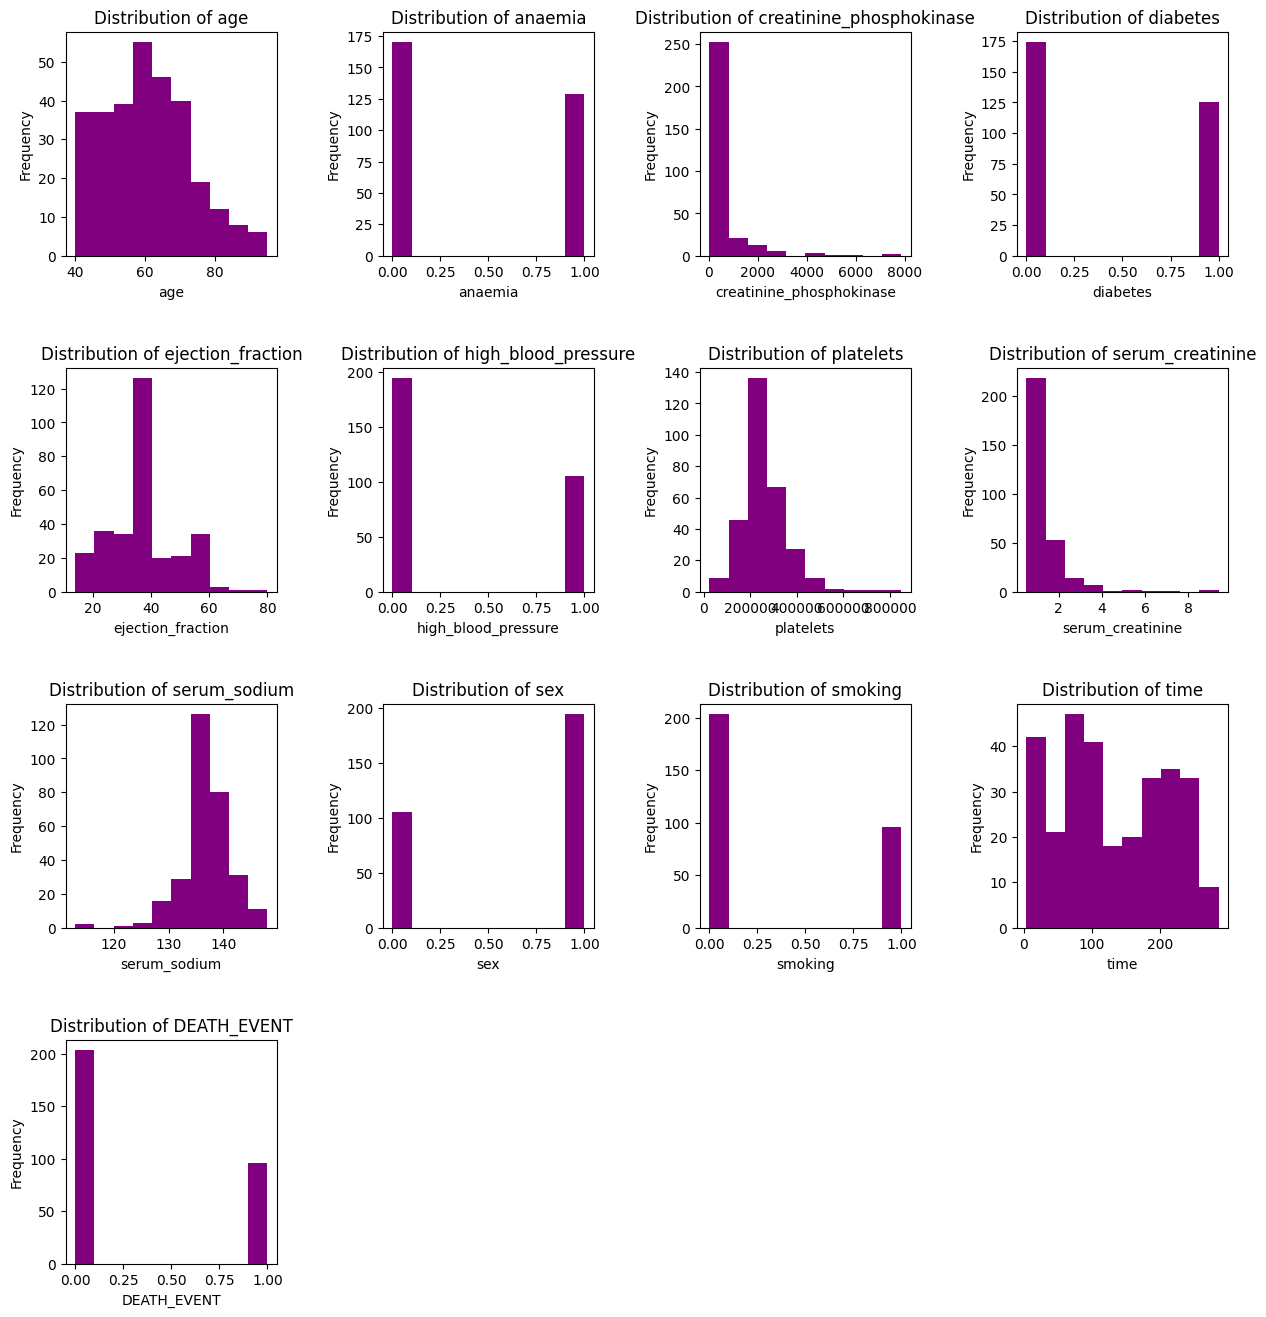

In [ ]:
#show distribution of variables
num_cols = 4

num_rows = (len(df.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust vertical spacing

axes = axes.flatten()

#plot
for i, column in enumerate(df.columns):
    ax = axes[i]
    df[column].plot(kind='hist', ax=ax, title=f"Distribution of {column}", color='purple')
    ax.set_xlabel(column)

# hide empty subplots
for i in range(len(df.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.show()


Additional insights:
* Age - mean age of 60
* Sex - there are more males than females
* death event - more patients survived than died (203 vs 96)

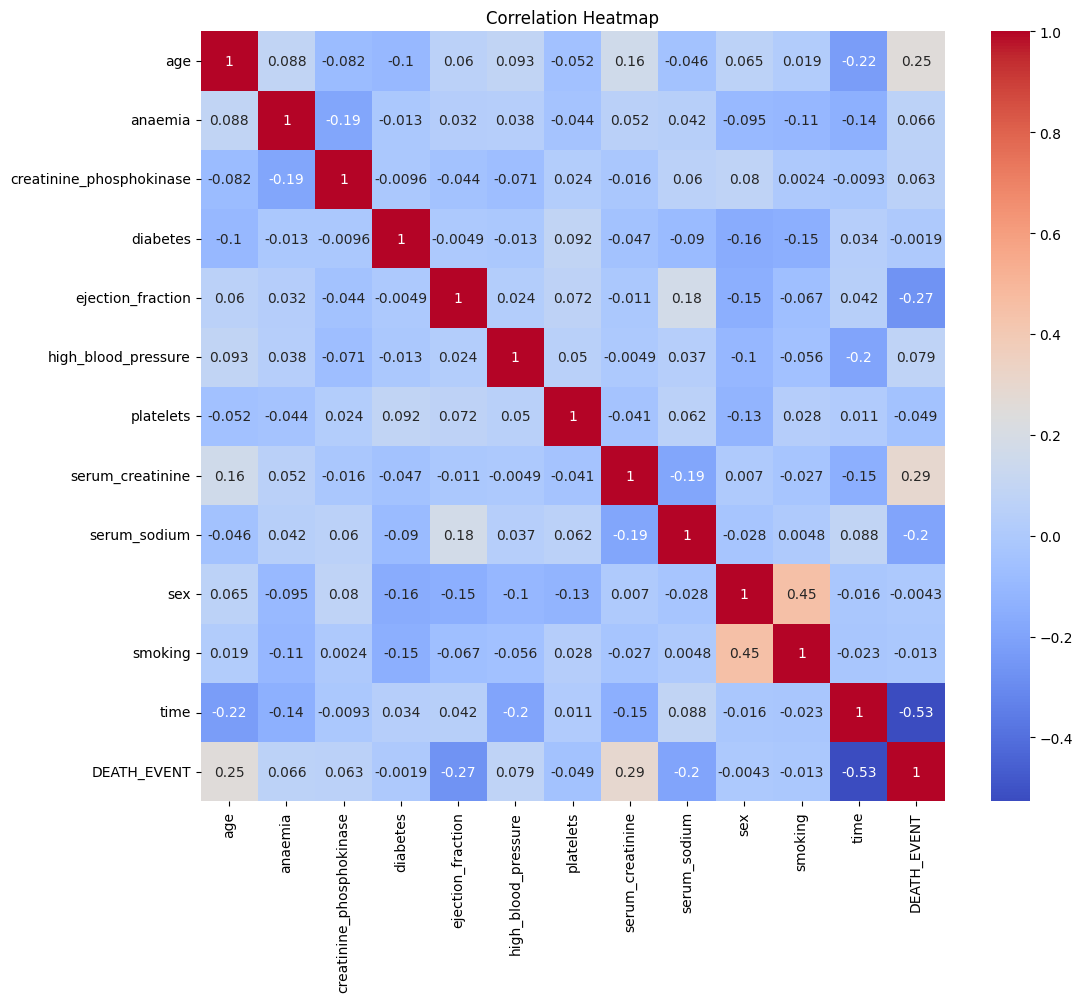

<Figure size 1200x1000 with 0 Axes>

In [ ]:
#show heatmap of correlations
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap')
plt.figure(figsize=(12, 10))
plt.show()

The strongest correlations are:

*  Time and Death Event (-0.53) - as time decreases, the likelihood of death increases
* Sex and Smoking (0.45) - certain gender groups tend to have higher rates of smoking
* Serum Creatinine and Death Event (0.29) - higher levels of creatinine increase likelihood of death
* Ejection Fraction and Death Event (-0.27) - lower ejection fraction increases likelihood of death
*  Age and Death Event (0.25) - as age increases, the likelihood of death increases

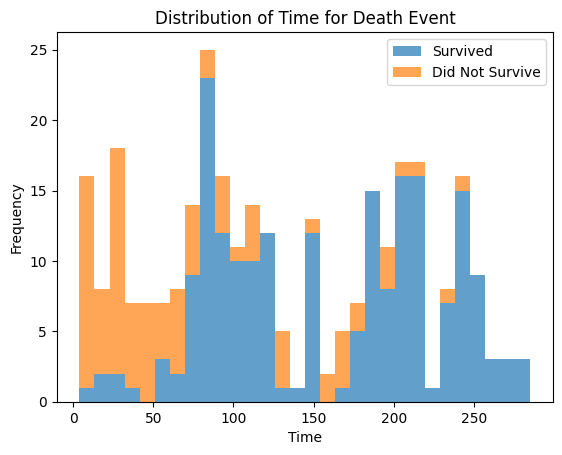

In [ ]:
survived = df[df['DEATH_EVENT'] == 0]
did_not_survive = df[df['DEATH_EVENT'] == 1]

# histogram
plt.hist([survived['time'], did_not_survive['time']], bins=30, stacked=True, alpha=0.7, label=['Survived', 'Did Not Survive'])

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Time for Death Event')
plt.legend()
plt.show()


Longer follow up periods show higher rates of survival, or a decrease in death.

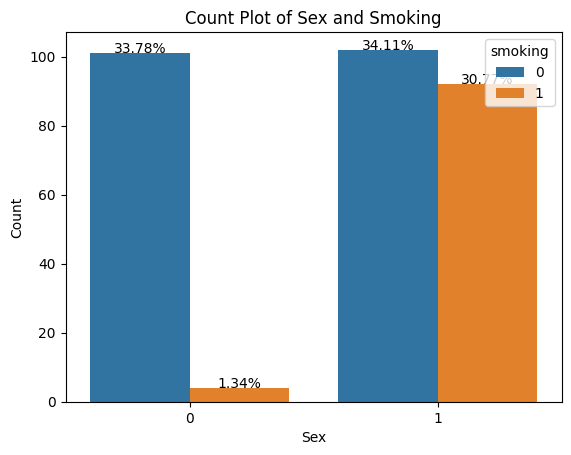

In [ ]:
ax = sns.countplot(x='sex', hue='smoking', data=df)

# get percentages
total = len(df['sex'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.02,
            f'{height/total:.2%}', ha='center')

plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Count Plot of Sex and Smoking')
plt.show()


The majority of patients did not smoke. Of those that did smoke, 4.2% were women and 95.8% were men.

# Machine Learning Modeling
## Logisitic Regression, Decison Tree, Random Forest, XGBoost

In [ ]:
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine' , 'serum_sodium' , 'sex', 'smoking' , 'time']]
y = df['DEATH_EVENT']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (239, 12)
Testing split input-  (60, 12)


In [ ]:
#define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

#loop through classifiers to evaluate
for clfname, clf in classifiers.items():
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print(f'Classifier - {clfname}')
  print(f'Accuracy Score - {clf}: {accuracy}')
  print(f'ROC AUC Score - {roc_auc}')

Classifier - Logistic Regression
Accuracy Score - LogisticRegression(): 0.85
ROC AUC Score - 0.8711111111111112
Classifier - Decision Tree
Accuracy Score - DecisionTreeClassifier(): 0.85
ROC AUC Score - 0.8333333333333334
Classifier - Random Forest
Accuracy Score - RandomForestClassifier(): 0.85
ROC AUC Score - 0.94
Classifier - XGBoost
Accuracy Score - XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              m

The XGBoost and Random Forest classifiers perform the best without hypertuning.

In [ ]:
from sklearn.model_selection import GridSearchCV

#define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False)
}

#define hyperparamters
param_grid = {
    'Logistic Regression': {'C': np.logspace(-3, 3, 7), 'penalty': ['l2']},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10, 50, 100, 150, 200], 'min_samples_leaf': [1, 2, 10]},
    'Random Forest': {'n_estimators': [10, 100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 10, 20]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
}

#loop through classifiers
for clf_name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid[clf_name], scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_clf = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])

    print(f'Classifier: {clf_name}')
    print(f'Best Hyperparameters: {grid_search.best_params_}')
    print(f'Accuracy Score: {accuracy}')
    print(f'ROC-AUC Score: {roc_auc}')

Classifier: Logistic Regression
Best Hyperparameters: {'C': 10.0, 'penalty': 'l2'}
Accuracy Score: 0.85
ROC-AUC Score: 0.8711111111111112
Classifier: Decision Tree
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 150}
Accuracy Score: 0.8333333333333334
ROC-AUC Score: 0.9103703703703704
Classifier: Random Forest
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy Score: 0.8833333333333333
ROC-AUC Score: 0.9540740740740741
Classifier: XGBoost
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy Score: 0.8666666666666667
ROC-AUC Score: 0.9377777777777778


After hypertuning, Random Forest performs the best. The classifiers did not improve significantly.

# Interpretability - eli5


In [ ]:
pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=a244ef839ed3d51503f69279bad50f6e051419bf182e891e76891319a51594d2
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import eli5

In [ ]:
#logistic regression eli5
lr = LogisticRegression()
lr.fit(X_train, y_train)
eli5.show_weights(lr, feature_names=list(X_train.columns))

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
# Reset the index of X_test
X_test_reset = X_test.reset_index(drop=True)
X_test_reset

In [ ]:
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

In [ ]:
print(X_test_reset.iloc[1])

age                             70.0
anaemia                          0.0
creatinine_phosphokinase      2695.0
diabetes                         1.0
ejection_fraction               40.0
high_blood_pressure              0.0
platelets                   241000.0
serum_creatinine                 1.0
serum_sodium                   137.0
sex                              1.0
smoking                          0.0
time                           247.0
Name: 1, dtype: float64


In [ ]:
#negative label at index 1

negative_label = X_test_reset.iloc[1]

eli5.show_prediction(lr, doc=negative_label, feature_names=list(X_test_reset.columns))

For this negative prediction, the patient's follow-up period (time) and percentage of blood leaving the heart at each contraction (ejection_fraction) are the most influential features in predicting the negative death label. A normal ejection fraction is 50% or higher. An ejection fraction below 40% means the heart isn't pumping enough blood ( [PennMedicine](https://www.pennmedicine.org/updates/blogs/heart-and-vascular-blog/2022/april/ejection-fraction-what-the-numbers-mean#:~:text=Ejection%20fraction%20is%20measured%20as,blood%20and%20may%20be%20failing.)).

In [ ]:
print(X_test_reset.iloc[3])

age                             87.0
anaemia                          1.0
creatinine_phosphokinase       149.0
diabetes                         0.0
ejection_fraction               38.0
high_blood_pressure              0.0
platelets                   262000.0
serum_creatinine                 0.9
serum_sodium                   140.0
sex                              1.0
smoking                          0.0
time                            14.0
Name: 3, dtype: float64


In [ ]:
#positive label at index 3

positive_label = X_test_reset.iloc[3]

eli5.show_prediction(lr, doc=positive_label, feature_names=list(X_test_reset.columns))

For this positive prediction, the patient's age, serum sodium level, platelet count, creatinine phosphokinase level, and serum creatinine level are the most influential features in predicting the positive death label.

In [ ]:
#decision tree with eli5
dt_params = {'max_depth': None, 'min_samples_leaf':1, 'min_samples_split':150}
dt = DecisionTreeClassifier(**dt_params)
dt.fit(X_train, y_train)
eli5.show_weights(dt, feature_names=list(X_train.columns))

In [ ]:
#negative label at index 1

negative_label1 = X_test_reset.iloc[1]

eli5.show_prediction(dt, doc=negative_label1, feature_names=list(X_test_reset.columns))

For this negative prediction, the base value, time, ejection fraction, and age are the top features influencing a negative prediction.

In [ ]:
#positive label

positive_label1 = X_test_reset.iloc[3]

eli5.show_prediction(dt, doc=positive_label1, feature_names=list(X_test_reset.columns))

For this positive prediction, the time and base value are the top features contribuiting to the positive label.

# Explanability - LIME and SHAP

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=26977ca0f8361b38859f9a5497c275d19635537211af369f904cab2a696f36f2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
#LIME
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
#random forest
rf_params = {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200}
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

#XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#rf LimeTabularExplainer
rf_explainer = LimeTabularExplainer(X_train.values, feature_names=list(X_train.columns), class_names=['Negative', 'Positive'], discretize_continuous=True)

In [ ]:
#xgb LimeTabularExplainer
xgb_explainer = LimeTabularExplainer(X_train.values, feature_names=list(X_train.columns), class_names=['Negative', 'Positive'], discretize_continuous=True)

In [ ]:
positive_instance = 16    #positive
instance_rf = X_test_reset.iloc[[positive_instance]]
instance_xgb = X_test_reset.iloc[[positive_instance]]

In [ ]:
# random forest explanation
rf_exp = rf_explainer.explain_instance(instance_rf.values[0], rf.predict_proba, num_features=len(X_test_reset.columns))
rf_exp.show_in_notebook(show_table=True, show_all=False)

# xgboost explanation
xgb_exp = xgb_explainer.explain_instance(instance_xgb.values[0], xgb.predict_proba, num_features=len(X_test_reset.columns))
xgb_exp.show_in_notebook(show_table=True, show_all=False)

# coefficients, intercept, and R2 for both explanations
rf_coefficients = np.array(rf_exp.as_list())
rf_intercept = rf_exp.intercept[1]
rf_r2 = rf_exp.score

xgb_coefficients = np.array(xgb_exp.as_list())
xgb_intercept = xgb_exp.intercept[1]
xgb_r2 = xgb_exp.score

print("Random Forest:")
print("Coefficients:", rf_coefficients)
print("Intercept:", rf_intercept)
print("R2:", rf_r2)
print()

print("XGBoost:")
print("Coefficients:", xgb_coefficients)
print("Intercept:", xgb_intercept)
print("R2:", xgb_r2)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Random Forest:
Coefficients: [['time <= 72.00' '0.3547118353274098']
 ['ejection_fraction <= 30.00' '0.1669268016703928']
 ['serum_creatinine > 1.50' '0.15916965760770396']
 ['serum_sodium <= 134.00' '0.058006988970622377']
 ['platelets > 303500.00' '0.01707844055463084']
 ['high_blood_pressure <= 0.00' '-0.0073907194356212375']
 ['sex <= 0.00' '0.0063950211732495404']
 ['0.00 < anaemia <= 1.00' '0.004597881601319815']
 ['60.00 < age <= 70.00' '-0.004385711370862144']
 ['0.00 < diabetes <= 1.00' '-0.003529836774027697']
 ['smoking <= 0.00' '-0.0033503680373087315']
 ['112.50 < creatinine_phosphokinase <= 245.00' '-0.001871421984553384']]
Intercept: 0.1726199781080031
R2: 0.8589069813054644

XGBoost:
Coefficients: [['time <= 72.00' '0.5872065344966225']
 ['ejection_fraction <= 30.00' '0.2954494403595127']
 ['serum_creatinine > 1.50' '0.18020787223784696']
 ['serum_sodium <= 134.00' '0.09225127094723135']
 ['platelets > 303500.00' '0.06632788877115998']
 ['sex <= 0.00' '0.054907688076016

For the Random Forest, time, serum creatinine, ejection fraction, serum sodium, and level of platelets are all the positive contributions. The R2 score of 0.86 indicates that the model is a good approximation of the black box model. For XGBoost, time, ejection fraction, serum creatinine, level of platelets, and serum sodium are the positive contributions. The R2 score of is lower at 0.61.

In [ ]:
negative_instance = 59    #negative
instance_rf1 = X_test_reset.iloc[[negative_instance]]
instance_xgb1 = X_test_reset.iloc[[negative_instance]]

In [ ]:
# random forest explanation
rf_exp = rf_explainer.explain_instance(instance_rf1.values[0], rf.predict_proba, num_features=len(X_test_reset.columns))
rf_exp.show_in_notebook(show_table=True, show_all=False)

# xgboost explanation
xgb_exp = xgb_explainer.explain_instance(instance_xgb1.values[0], xgb.predict_proba, num_features=len(X_test_reset.columns))
xgb_exp.show_in_notebook(show_table=True, show_all=False)

# coefficients, intercept, and R2 for both explanations
rf_coefficients = np.array(rf_exp.as_list())
rf_intercept = rf_exp.intercept[1]
rf_r2 = rf_exp.score

xgb_coefficients = np.array(xgb_exp.as_list())
xgb_intercept = xgb_exp.intercept[1]
xgb_r2 = xgb_exp.score


print("Random Forest:")
print("Coefficients:", rf_coefficients)
print("Intercept:", rf_intercept)
print("R2:", rf_r2)
print()

print("XGBoost:")
print("Coefficients:", xgb_coefficients)
print("Intercept:", xgb_intercept)
print("R2:", xgb_r2)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Random Forest:
Coefficients: [['serum_creatinine > 1.50' '0.16315887196643042']
 ['time > 196.50' '-0.1527364528572803']
 ['30.00 < ejection_fraction <= 38.00' '-0.07786321927864509']
 ['137.00 < serum_sodium <= 140.00' '-0.02492303174993598']
 ['260000.00 < platelets <= 303500.00' '-0.016064566226366588']
 ['245.00 < creatinine_phosphokinase <= 582.00' '0.014798861462780796']
 ['anaemia <= 0.00' '-0.012289445223432765']
 ['high_blood_pressure <= 0.00' '-0.00893256938480032']
 ['smoking <= 0.00' '-0.006387646839790127']
 ['60.00 < age <= 70.00' '-0.00400853545051221']
 ['sex <= 0.00' '0.0036292985210609474']
 ['diabetes <= 0.00' '0.0025632601072923746']]
Intercept: 0.41144998820932116
R2: 0.268307747194521

XGBoost:
Coefficients: [['time > 196.50' '-0.4517134967349775']
 ['serum_creatinine > 1.50' '0.1820426617442057']
 ['30.00 < ejection_fraction <= 38.00' '-0.10113339729067033']
 ['137.00 < serum_sodium <= 140.00' '-0.0653047491603957']
 ['sex <= 0.00' '0.05415375460456418']
 ['245.0

When predicting a negative instance, neither model performs well will very low R2 scores. This indicates that the linear model that LIME fitted is not a good approximation of the model for negative instances.

In [ ]:
#SHAP
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
# TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb)

# SHAP values
shap_values = explainer.shap_values(X_test_reset)

[23:04:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
shap.initjs()

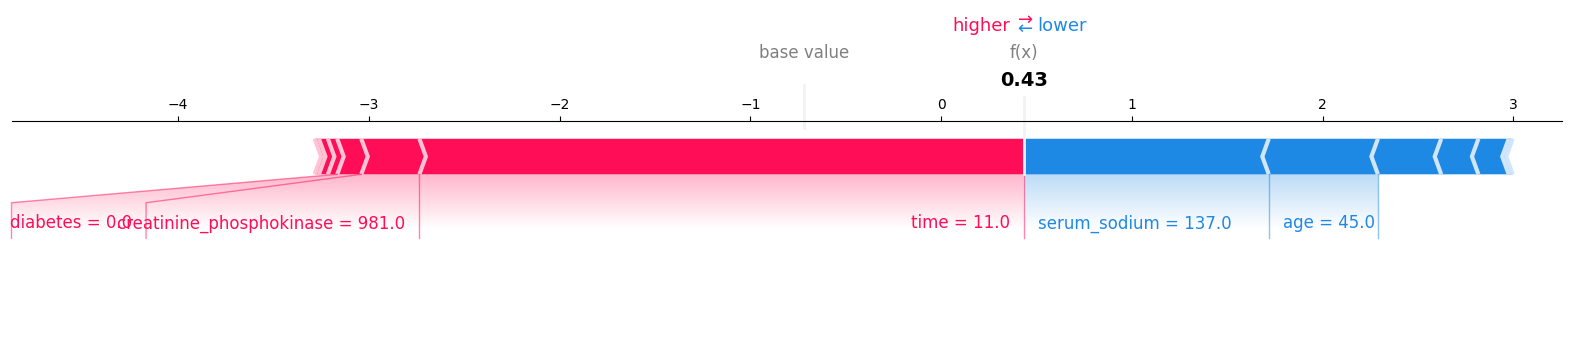

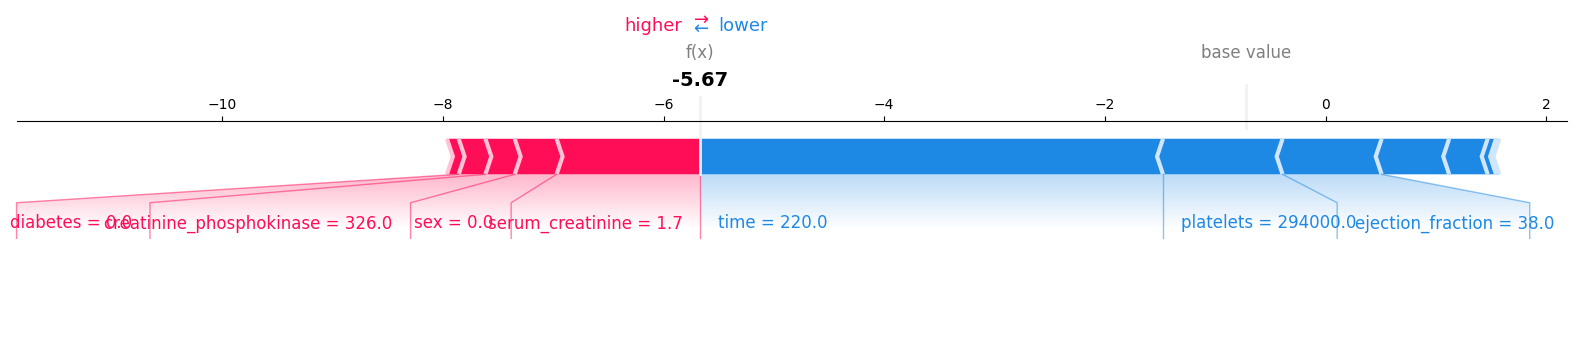

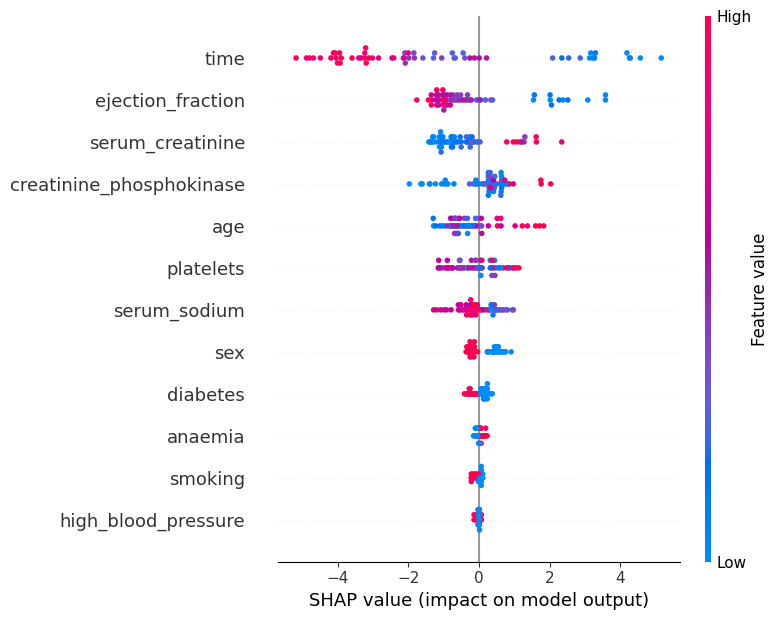

In [ ]:
positive_instance = 2
negative_instance = 59

# force_plot for positive instance
shap.force_plot(explainer.expected_value, shap_values[positive_instance, :], X_test_reset.iloc[positive_instance, :], matplotlib=True)

# force_plot for negative instance
shap.force_plot(explainer.expected_value, shap_values[negative_instance, :], X_test_reset.iloc[negative_instance, :], matplotlib=True)

# feature importance plot using summary_plot function for each class
shap.summary_plot(shap_values, X_test_reset)




*   Time: Instances with lower time values contribute more to the prediction of a positive death label.
*   Ejection Fraction:  Instances with lower ejection fraction values have a stronger positive impact on the prediction of death.
* Serum Creatinine:  Instances with higher serum creatinine values contribute more to predicting a positive death label.
* Creatine phosphokinase: Instances with higher creatine phosphokinase values contribute more to predicting a positive death label.
* Age: Instances with higher age values have a stronger positive impact on predicting death.

These observations suggest that certain medical indicators such as lower ejection fraction, higher serum creatinine, and older age contribute to an increased probability of predicting a positive death label. Time also seems to play a role, where lower time values are associated with a higher likelihood of a positive death label. However, other studies might want to exclude time variable when trying to find the medical causes of heart failure.




# Predictions

In [ ]:
# Logistic Regression prediction
lr_probs = lr.predict_proba(X_test_reset)
lr_predictions = lr.predict(X_test_reset)

# Decision Tree prediction
dt_probs = dt.predict_proba(X_test_reset)
dt_predictions = dt.predict(X_test_reset)

# Random Forest prediction
rf_probs = rf.predict_proba(X_test_reset)
rf_predictions = rf.predict(X_test_reset)

# XGBoost prediction
xgb_probs = xgb.predict_proba(X_test_reset)
xgb_predictions = xgb.predict(X_test_reset)

# Caccuracy score
lr_accuracy = accuracy_score(y_test_reset, lr_predictions)
dt_accuracy = accuracy_score(y_test_reset, dt_predictions)
rf_accuracy = accuracy_score(y_test_reset, rf_predictions)
xgb_accuracy = accuracy_score(y_test_reset, xgb_predictions)

print(f"LR Accuracy: {lr_accuracy:.4f}")
print(f"DT Accuracy: {dt_accuracy:.4f}")
print(f"RF Accuracy: {rf_accuracy:.4f}")
print(f"XGB Accuracy: {xgb_accuracy:.4f}")

positive_label_index = 2
negative_label_index = 1

# Logistic Regression probabilities
lr_positive_probs = lr_probs[positive_label_index]
lr_negative_probs = lr_probs[negative_label_index]

# Decision Tree probabilities
dt_positive_probs = dt_probs[positive_label_index]
dt_negative_probs = dt_probs[negative_label_index]

# Random Forest probabilities
rf_positive_probs = rf_probs[positive_label_index]
rf_negative_probs = rf_probs[negative_label_index]

# XGBoost probabilities
xgb_positive_probs = xgb_probs[positive_label_index]
xgb_negative_probs = xgb_probs[negative_label_index]

print("\nProbabilities for Positive Label:")
print(f"LR: {lr_positive_probs}")
print(f"DT: {dt_positive_probs}")
print(f"RF: {rf_positive_probs}")
print(f"XGB: {xgb_positive_probs}")

print("\nProbabilities for Negative Label:")
print(f"LR: {lr_negative_probs}")
print(f"DT: {dt_negative_probs}")
print(f"RF: {rf_negative_probs}")
print(f"XGB: {xgb_negative_probs}")



LR Accuracy: 0.8500
DT Accuracy: 0.8333
RF Accuracy: 0.9333
XGB Accuracy: 0.9000

Probabilities for Positive Label:
LR: [0.28537305 0.71462695]
DT: [0.15517241 0.84482759]
RF: [0.40416457 0.59583543]
XGB: [0.39334762 0.6066524 ]

Probabilities for Negative Label:
LR: [0.92496739 0.07503261]
DT: [0.93846154 0.06153846]
RF: [0.87821205 0.12178795]
XGB: [0.99376184 0.00623818]


The models demonstrate good overall performance, with accuracy scores ranging from 83% to 93%. Notably, the Random Forest model outperforms the others with the highest accuracy of 93%. Looking at the predicted probabilities for positive and negative labels provides more insight into the patterns. The range for positive probabilities is 61-84%, compared to negative probabilities with a range of 82-99%. For example, XGBoost has a 99.4% confidence in predicting negative labels, compared with only 60.7% confidence in predicting positive labels. This disparity in probabilities is seen in the all models, and may indicate a potential bias toward negative predictions due to an imbalanced dataset.